# 🌍 Sentinel-2 Data Processing and Normalization

Unlike last year, we decided to change the representation of Sentinel-2 data, and rather than use the "compressed" JPEG data, we provided the raw values in TIFF files, which provided some benefits.
To make it easier for you, we provide this tutorial on how to work with the data. In this notebook, we cover: 
- **Understanding TIFF vs. JPG**: Why TIFF is better for geospatial analysis.
- **Exploring Sentinel-2's 4 Bands**: What information they provide.
- **Loading and Visualizing TIFF Data**: Using rasterio, matplotlib and folium.
- **Normalization Techniques**: Different approaches to scale raw Sentinel-2 values, including Log Normalization (LOD).

## ✅ Step1: Installing Rasterio and Folium
- `rasterio` is a powerful library for reading and writing raster datasets, essential for handling Sentinel-2 imagery.
- `folium` is a lightweight library for interactive map visualization, useful for geospatial data overlay and exploration.

**If you haven't installed them yet, run the command below.**

**Alternative Approach:** Consider using `GDAL` for more extensive geospatial data support.

In [1]:
!pip install rasterio
!pip install folium

## ✅ Step 2: Loading Essential Libraries
For further processing, we nned to import some Python libraries for data processing:
- `numpy`: For numerical operations.
- `pandas`: For handling tabular data, especially CSV files.
- `rasterio`: For handling geospatial raster data.
- `matplotlib.pyplot`: For visualizing data.
- `numpy`: For numerical computations.

In [2]:
import numpy as np
import pandas as pd

import folium
import rasterio
import matplotlib.pyplot as plt
from folium.raster_layers import ImageOverlay
from folium.plugins import MousePosition
from rasterio.warp import calculate_default_transform, reproject, Resampling

import os

## ✅ Step 3: Understanding TIFF vs. JPG

**Why Use TIFF over JPG?**
- **Multi-band Support**: TIFF stores multiple spectral bands (e.g., Sentinel-2 has 4+ bands).
- **Higher Precision**: TIFF supports floating-point values, while JPG is limited to 8-bit integers.
- **No Compression Loss**: TIFF retains original sensor data, while JPG introduces artifacts.
- **Better for Analysis**: Geospatial calculations (e.g., NDVI) require accurate reflectance values.

In [3]:
# Open the file
test_file = '../data/SatellitePatches/PA-test/00/00/5000000.tiff'

with rasterio.open(test_file) as src:
    print('Metadata:')
    print(src.meta)
    
    print('\nBand count:', src.count)

    # Loop over each band to see what info is there
    for idx in range(1, src.count + 1):
        desc = src.descriptions[idx - 1]
        print(f'Band {idx}: {desc}')

Metadata:
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -1.0, 'width': 64, 'height': 64, 'count': 4, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown_based_on_GRS80_ellipsoid",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(10.0, 0.0, 2945830.0,
       0.0, -10.0, 2304670.0)}

Band count: 4
Band 1: red
Band 2: green
Band 3: blue
Band 4: nir


## ✅ Step 4: Load Sentinel-2 TIFF File and Visualize the Bands

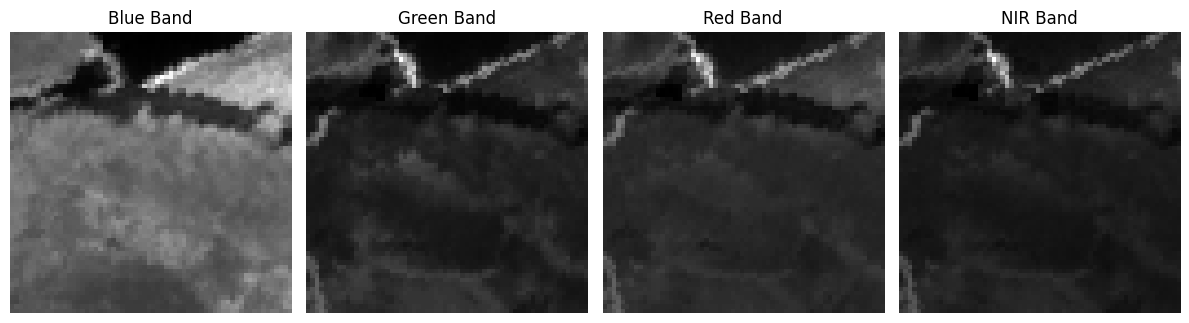

In [4]:
file_path = test_file
with rasterio.open(file_path) as dataset:
    image = dataset.read()  # Reads all bands


fig, axes = plt.subplots(1, 4, figsize=(12, 4))
band_names = ['Blue', 'Green', 'Red', 'NIR']

# Display the individual bands
for i in range(4):
    axes[i].imshow(image[i-1], cmap='gray')
    axes[i].set_title(f"{band_names[i]} Band")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## ✅ Step 5: Normalizing Sentinel-2 Data

📌 **Why Normalize?**
- Sentinel-2 values range from 0 to 10,000 (scaled reflectance).
- Normalization helps standardize data for ML models and visualization.

🔄 **So, what are the different normalization approaches?**
- 1️⃣ **Min-Max Scaling** (scales values to [0,1])
- 2️⃣ **Standardization (Z-Score)** (centers around mean with unit variance)
- 3️⃣ **Histogram Equalization** (enhances contrast)
- 4️⃣ **Log Scaling (LOD)** (useful for highly skewed distributions)

### ✅ Step 5.1: Plotting Histograms of Raw Bands Before Normalization

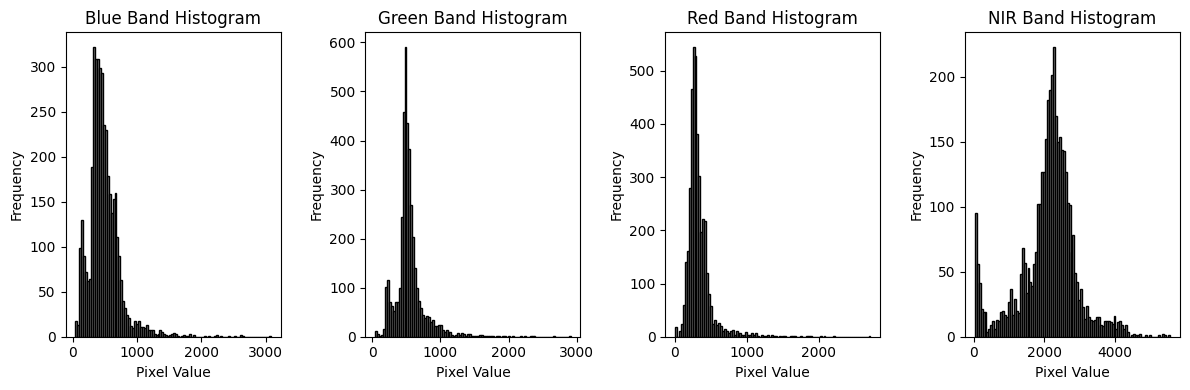

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

# Plot histograms for each band
for i in range(4):
    axes[i].hist(image[i].flatten(), bins=100, color='gray', edgecolor='black')
    axes[i].set_title(f"{band_names[i]} Band Histogram")
    axes[i].set_xlabel("Pixel Value")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### ✅ Step 5.2: Functions for Bands Normalization

In [6]:
def safe_rescale_to_255(band):
    """Rescale the band to [0, 255] and clip values."""
    return np.clip(band * 255, 0, 255).astype(np.uint8)

def min_max_normalize(band):
    """Normalize the band to [0, 1] and rescale to [0, 255]."""
    normalized = (band - band.min()) / (band.max() - band.min())
    return safe_rescale_to_255(normalized)

def standardize(band):
    """Standardize the band and rescale to [0, 255]."""
    standardized = (band - band.mean()) / band.std()
    return safe_rescale_to_255(np.clip(standardized, 0, 1))

def log_normalize(band):
    """Log normalize the band and rescale to [0, 255]."""
    normalized = np.log1p(band - band.min()) / np.log1p(band.max() - band.min())
    return safe_rescale_to_255(normalized)

def quantile_normalize(band, low=2, high=98):
    """Normalize the band based on quantiles and rescale to [0, 255]."""
    sorted_band = np.sort(band.flatten())
    quantiles = np.percentile(sorted_band, np.linspace(low, high, len(sorted_band)))
    normalized_band = np.interp(band.flatten(), sorted_band, quantiles).reshape(band.shape)
    min_val = np.min(normalized_band)
    max_val = np.max(normalized_band)
    return safe_rescale_to_255((normalized_band - min_val) / (max_val - min_val))

In [7]:
data_min_max = np.array([min_max_normalize(band) for band in image])
data_log = np.array([log_normalize(band) for band in image])
data_quantile = np.array([quantile_normalize(band) for band in image])

### ✅ Step 5.3: Visualizing All Bands and All Normalizations in One Figure

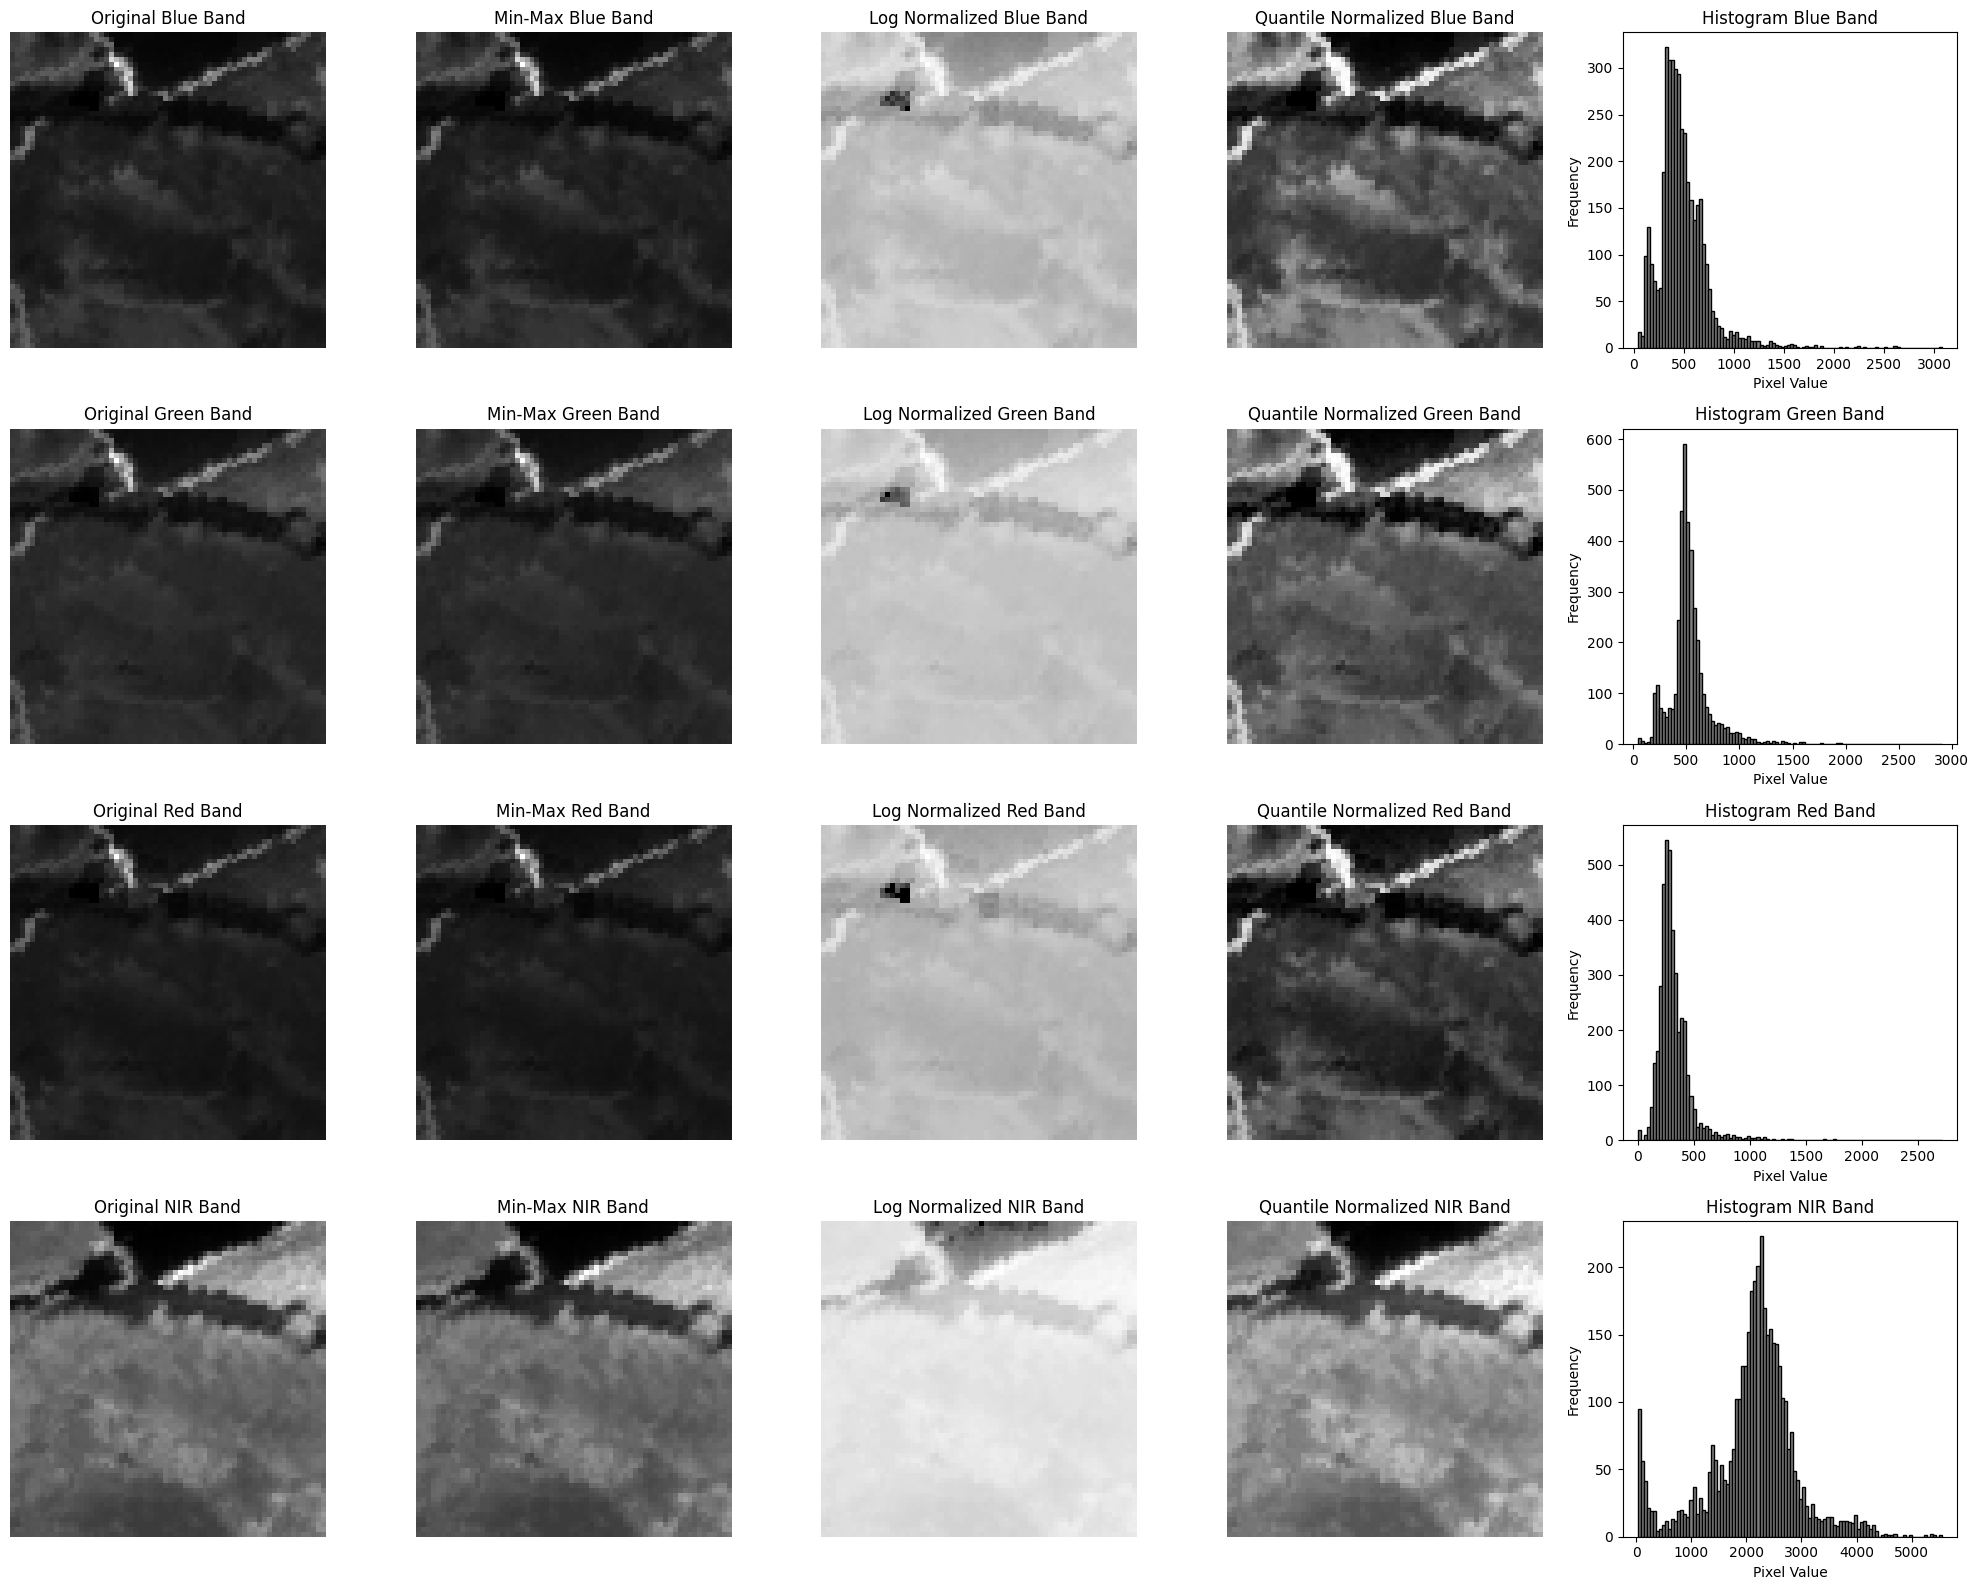

In [8]:
fig, axes = plt.subplots(4, 5, figsize=(20, 16))

# Original Bands (Raw data)
for i in range(4):
    axes[i, 0].imshow(image[i], cmap='gray')
    axes[i, 0].set_title(f"Original {band_names[i]} Band")
    axes[i, 0].axis('off')

# Min-Max Normalized Bands
for i in range(4):
    axes[i, 1].imshow(data_min_max[i], cmap='gray')
    axes[i, 1].set_title(f"Min-Max {band_names[i]} Band")
    axes[i, 1].axis('off')

# Log Normalized Bands
for i in range(4):
    axes[i, 2].imshow(data_log[i], cmap='gray')
    axes[i, 2].set_title(f"Log Normalized {band_names[i]} Band")
    axes[i, 2].axis('off')

# Quantile Normalized Bands
for i in range(4):
    axes[i, 3].imshow(data_quantile[i], cmap='gray')
    axes[i, 3].set_title(f"Quantile Normalized {band_names[i]} Band")
    axes[i, 3].axis('off')

# Histograms of Original Bands
for i in range(4):
    axes[i, 4].hist(image[i].flatten(), bins=100, color='gray', edgecolor='black')
    axes[i, 4].set_title(f"Histogram {band_names[i]} Band")
    axes[i, 4].set_xlabel("Pixel Value")
    axes[i, 4].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### ✅ Step 5.4: Visualizing RGB Image with No and All Normalizations


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1..3082].


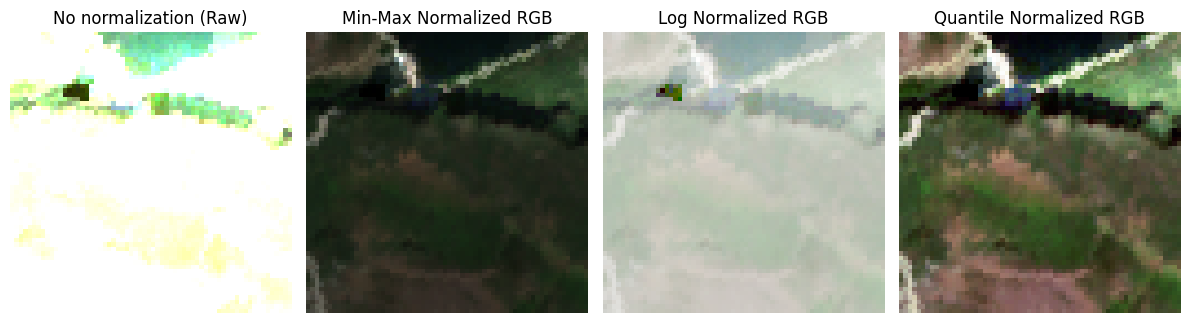

In [9]:
def create_rgb_image(red, green, blue):
    """
    Combine the Red, Green, and Blue bands into a single RGB image.
    """
    # Stack the bands along the third axis to create an RGB image
    return np.stack((red, green, blue), axis=-1)

# Create RGB composites for raw and normalized bands
rgb_original = create_rgb_image(image[0], image[1], image[2])  # Red, Green, Blue bands (original)
rgb_min_max = create_rgb_image(data_min_max[0], data_min_max[1], data_min_max[2])  # Min-Max normalized
rgb_log = create_rgb_image(data_log[0], data_log[1], data_log[2])  # Log normalized
rgb_quantile = create_rgb_image(data_quantile[0], data_quantile[1], data_quantile[2])  # Quantile normalized

# Visualize all RGB images in one figure
fig, axes = plt.subplots(1, 4, figsize=(12, 12))

# RGB - No normalization (Raw)
axes[0].imshow(rgb_original)
axes[0].set_title("No normalization (Raw)")
axes[0].axis('off')

# Min-Max Normalized RGB Image
axes[1].imshow(rgb_min_max)
axes[1].set_title("Min-Max Normalized RGB")
axes[1].axis('off')

# Log Normalized RGB Image
axes[2].imshow(rgb_log)
axes[2].set_title("Log Normalized RGB")
axes[2].axis('off')

# Quantile Normalized RGB Image
axes[3].imshow(rgb_quantile)
axes[3].set_title("Quantile Normalized RGB")
axes[3].axis('off')

# Make sure the layout is tight
plt.tight_layout()
plt.show()

## ✅ Step 6: Reproject the patch to WGS84 and Visualize using Rasterio.

In [10]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling

def reproject_to_wgs84(src_path, dst_path):
    with rasterio.open(src_path) as src:
        dst_crs = 'EPSG:4326'
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height,
            'nodata': None  # Set nodata to None to avoid adding black/zero values
        })
        
        with rasterio.open(dst_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

src_tiff = test_file
reprojected_tiff = "reprojected_patch_wgs84.tif"
reproject_to_wgs84(src_tiff, reprojected_tiff)

In [11]:
with rasterio.open(reprojected_tiff) as tiff_file:
    image = tiff_file.read()
    bounds = tiff_file.bounds
data_quantile = np.array([quantile_normalize(band) for band in image])
rgb_quantile = create_rgb_image(data_quantile[0], data_quantile[1], data_quantile[2])  # Quantile normalized

In [12]:
# Center point of the patch
center_lat = (bounds.top + bounds.bottom) / 2
center_lon = (bounds.left + bounds.right) / 2

# Create folium map with Google Satellite background
m = folium.Map(location=[center_lat, center_lon], zoom_start=16, tiles=None)

# Add Google Satellite basemap
folium.TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google Satellite',
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(m)

# Define the bounds for overlays
img_bounds = [[bounds.bottom, bounds.left], [bounds.top, bounds.right]]

# Add RGB composite overlay
rgb_overlay = ImageOverlay(
    name='RGB Composite',
    image=rgb_quantile,
    bounds=img_bounds,
    opacity=0.4
)
rgb_overlay.add_to(m)

# Add controls
folium.LayerControl().add_to(m)
MousePosition().add_to(m)


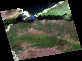

In [13]:
m